# Modeling Temperature based off greenhouse gases

By Kevin Linnane and Mykel Mcleish


We have scraping code to get all the needed data, but not included in here as there was parsing afterwards to make sure the data was correct.  We scraped two websites to get CH4, and CO2.  The greenhouse gases were from ESLR and the weather data is from kaggle.  

This is the world controller class.  Here we mainly aggregate weather data to be used within this class.

In [1]:
from datetime import datetime
import pandas as pd
import glob
import numpy as np
from matplotlib import pyplot
#change this class to contioulsy run in future.

##MAIN##

## CREATE/PARSE DATA FOR ML MODEL##


##CREATE OBJECTS FOR EACH CITY##
## City obj will handle data passed in through none statements
#CountryObj() # only do UNITED STATES
class WorldController:
    def __init__(self, oo = False):
        if oo:
            cityCountryDict = {}
            for file in glob.glob("./data/weather/*City*"):
                weatherCityData = pd.read_csv(file, header=0, index_col='dt', infer_datetime_format=True)
                weatherCityData = weatherCityData[weatherCityData['Country'] == 'United States' ]

                weatherGroup = weatherCityData.groupby(['Longitude', 'Latitude'])

                for  key, item in weatherGroup:
                    for city in item.City.unique():
                        cityCountryDict[city]   =  {'Location': [*item.Longitude.unique(), *item.Latitude.unique()]}
                # remove break

            allWeatherCityData = pd.DataFrame()
            for file in glob.glob("./data/weather/*City*"):
                weatherCityData = pd.read_csv(file, header=0, index_col='dt')

                weatherCityData = weatherCityData[weatherCityData['Country'] == 'United States']
                weatherCityData.index = pd.to_datetime(weatherCityData.index)
                weatherCityData = weatherCityData[weatherCityData.index.year >= 1960]
                weatherCityData = weatherCityData[weatherCityData.index.year <= 2012]
                allWeatherCityData = allWeatherCityData.append(weatherCityData)
                for key in cityCountryDict.keys():
                    #pd.DataFrame(weatherCityData['AverageTemperature'].resample('W').sum(), columns=['AverageTemperature'])
                    weatherDict = weatherCityData[weatherCityData['City'] == key]['AverageTemperature']
                    i = 0
                    cityCountryDict[key]['time'] = []
                    for date in weatherDict.index.to_pydatetime():
                        otherDict = {date.strftime("%Y-%m-%d"): weatherDict.values[i]}
                        cityCountryDict[key]['time'].append(otherDict)
                        i+=1
                # remove break

            #cityCountryDict has City as key, Location : [longitude, latitude], time: [{WEEK TIMESTAMP : weather}...*]. Each child will find data to fit with its parent classes to pass data to it.  (read the csv, etc.)
            allStateData = pd.read_csv('./data/weather/GlobalLandTemperaturesByState.csv')
            allStateData = allStateData[allStateData['Country'] =='United States']
            allStateData.dt = pd.to_datetime(allStateData.dt)
            allStateData = allStateData.set_index(drop=True, keys='dt')

            #get weather data from 1960 and above.
            allStateData = allStateData[allStateData.index.year>=1960]#.resample('W').mean()['AverageTemperature']
            allStateData = allStateData[allStateData.index.year<2012]
            allStates = []
            for state in allStateData['State'].unique():
                otherData = allStateData[allStateData['State'] == state]
                allStates.append(StateObj(state, otherData))


            for city in cityCountryDict.keys():
                 cityStateName = findState(longitude=cityCountryDict[city]['Location'][0], latitude=cityCountryDict[city]['Location'][1])
                 for state in allStates:
                     if cityStateName == state.getStateName():
                         state.createCity(longitude=cityCountryDict[city]['Location'][0], latitude=cityCountryDict[city]['Location'][1], cityName=city, data=cityCountryDict[city]['time'])
                         #need this break.  Found the state.
                         break
                     if cityStateName == 'StateNA':
                         state.createCity(longitude=cityCountryDict[city]['Location'][0], latitude=cityCountryDict[city]['Location'][1], cityName=city, data=cityCountryDict[city]['time'])
                         break


            # this is only class attribute that will be used
            self.states = allStates
            self.longLat = weatherCityData


        else:
            weatherCityData = pd.read_csv('./data/weather/unitedStatesTemp.csv', header=0, index_col='dt')
            weatherCityData.index = pd.to_datetime(weatherCityData.index)
            weatherCityData = weatherCityData[weatherCityData.index.year >= 1960]
            weatherCityData = weatherCityData[weatherCityData.index.year <= 2012]
            weatherCityData.Latitude = weatherCityData.Latitude.apply(parseLat)
            weatherCityData.Longitude = weatherCityData.Longitude.apply(parseLong)

            self.monthDict = {1: None, 2: None, 3: None, 4: None, 5: None, 6: None, 7: None, 8: None, 9: None, 10: None, 11: None, 12:None}
            for name, group in weatherCityData.groupby(by=[weatherCityData.index.month]):

                self.monthDict[group.index[0].month] = group
            #print (monthDict)
            averageMonthDict = {1: None, 2: None, 3: None, 4: None, 5: None, 6: None, 7: None, 8: None, 9: None, 10: None, 11: None, 12:None}
            for dataFrame in self.monthDict.keys():
                averageMonthDict[dataFrame] = self.monthDict[dataFrame].groupby(by=self.monthDict[dataFrame].index).agg('mean')['AverageTemperature']
            #monthDict[1].to_csv('month1 temperatures')
            self.graphMonthlyChange(averageMonthDict)
            self.calculatePerIncrease(averageMonthDict)

        




    def calculatePerIncrease(self, aDict):
        for key in aDict.keys():
            print('%increase for month {}  == {}'.format(key, ((aDict[key][-1] - aDict[key][0])/aDict[key][0])*100 ) )


    def graphMonthlyChange(self, aDict):
        for key in aDict.keys():
            pyplot.plot(aDict[key], label=key)
        #pyplot.plot(graphed)
        pyplot.xlabel('Years')
        pyplot.ylabel('Temperature in Celsius')
        pyplot.legend()
        pyplot.savefig('./generatedData/monthDataWithlegend')

        pyplot.figure().clear()

    def getDfToTrain(self,sf6, n2o, co2, ch4):
        sf6 = self.createMonthYear(sf6)
        n2o = self.createMonthYear(n2o)
        co2 = self.createMonthYear(co2)
        ch4 = self.createMonthYear(ch4)
        dfMonthArray = []
        for keys in self.monthDict:
            month1 = pd.DataFrame(self.monthDict[keys][['AverageTemperature', 'Latitude', 'Longitude']])
            month1['sf6'] = np.nan
            month1['n2o'] = np.nan
            month1['co2'] = np.nan
            month1['ch4'] = np.nan
            monthParsed = month1.reset_index()
            i =0
            for index, row in monthParsed.iterrows():
                #print(sf6.loc[index.date()].values[0])
                ymRow = "{}/{}".format(row['dt'].year, row['dt'].month)
                month1['sf6'].iloc[i] = sf6[sf6['index'] == ymRow]['average'].values[0]
                month1['n2o'].iloc[i] = n2o[n2o['index'] == ymRow]['average'].values[0]
                month1['co2'].iloc[i] = co2[co2['index'] == ymRow]['CarbonEmissions'].values[0]
                month1['ch4'].iloc[i] = ch4[ch4['index'] == ymRow]['average'].values[0]
                i+=1
            month1.reset_index(drop=True, inplace=True)
            dfMonthArray.append(month1)
        return dfMonthArray

    def getMonthDict(self):
        return self.monthDict
    
    def createMonthYear(self, df):
        sf6YearMonth = []
        for i in range(0, len(df.index.year)):
            sf6YearMonth.append('{}/{}'.format(df.index[i].year, df.index[i].month ))
        df = df.reset_index()
        df['index'] = pd.Series(sf6YearMonth)
        return df

    def train_state_models(self):
        stateModel = "" # should be linear/log model
        for state in self.states:
            #get each state name, use it in conjuncation with the greenhouse gasses.
            state.getStateName()
        return stateModel

    def train_city_models(self):
        pass
def parseLong( longitude): #east negative
    if 'E' in longitude:
        return   float(longitude.replace('E', ''))
    else:
        return (-1) * float(longitude.replace('W', ''))

def parseLat( latitude): #north south
    if 'S' in latitude:
        return  (-1) *float(latitude.replace('S', ''))
    else:
        return float(latitude.replace('N', ''))
## Right here, create ML model.


##


#Once city populated, inf. while loop to get input for a city/state/country day(the next days sf6/co2/ch4/etc
# levels will be calculted and put into the model we have trained to predict #
#given a day, calculate greenhouse level gasses from our formula, and input to city params to be processed with given data
#if __name__ == "__main__":
#    WorldController()



Here we have created an object that stores three dataframes when used. One for months, days, and weeks in case we want to use different types of time periods for predictions.  As it stands, we will be using the month data frames as our main focus.  

In [2]:
import pandas as pd
import glob
from calendar import monthrange
import datetime as dt
import numpy as np
from matplotlib import pyplot as plt
class DateMod():
    yearDataFrame = None
    monthDataFrame = None
    weekDataFrame = None
    dayDataFrame = None
    dataName = None
    colVa1 = None
    def __init__(self, df, colValName, name):
        if "month" in df.keys():
            self.month_to_days(df,colValName)
        elif 'year' in df.keys():
            self.year_to_days(df,colValName)
        self.dataName = name
        self.colVal = colValName
        #TODO: fill in nan values created from months_to_day (They will = 0) to predicted ones.
    # testing on ch4, go up to 2014
    #returns dataframe with datetime as index, and values for each day given
    def year_to_days(self,df, colValName):
        dateObjs = []
        dateVals = []
        for i, y in enumerate(df.year):
            if y >= 1960:
                start = dt.date(y, 1, 1)
                end = dt.date(y+1,1, 1)
                date = start
                days = (end - start).days
                value = df[colValName][i]
                while date != end:
                    dateObjs.append(date)
                    dateVals.append(value/days)
                    date += dt.timedelta(days=1)
        df = pd.DataFrame(dateVals, index=dateObjs, columns=[colValName])
        df.index = pd.to_datetime(df.index)
        self.dayDataFrame = df
        self.yearDataFrame = pd.DataFrame(df[colValName].resample('Y').sum(), columns=[colValName])
        self.monthDataFrame = pd.DataFrame(df[colValName].resample('M').sum(), columns=[colValName])
        self.weekDataFrame = pd.DataFrame(df[colValName].resample('W').sum(), columns=[colValName])
    def month_to_days(self, df, colValName):
        dateObjs = []
        dateVals = []
        if int(df.year[0]) > 1960:

            diff = int(df.year[0]) - 1960
            # find delta, and append to month range list

            for year in range(diff+1):
                for month in range(1, 13):
                    # check if current year needs months added
                    if 1960+year == int(df.year[0]) and int(df.month[0]) == month:
                        break
                    for days in range(1, (monthrange(int(df.year[0]) + year, month)[1])):
                        dateObjs.append(dt.datetime(1960+year, month, days))
                        dateVals.append(np.nan)
        # add known dates to monthrange
        for index, row in df.iterrows():
            # check if row and month exist in delta time, if it doesn't add it.

            numDaysInMonth = (monthrange(int(row['year']), int(row['month']))[1])
            valueToAppendToDay = int(row[colValName])/numDaysInMonth
            for days in range(1, numDaysInMonth+1):
                dateObjs.append(dt.datetime(int(row['year']), int(row['month']), days))
                dateVals.append(valueToAppendToDay)

        # TODO HERE:  add dates after the end date of the given df to equal 2019.... maybe..
        df = pd.DataFrame(dateVals, index=dateObjs, columns=[colValName])
        Y = regrade_lin([x for x in range(len(df[colValName].values.tolist()))],df[colValName].values.tolist())
        for val in Y:
            if val > 0:
                try:
                    foo = 1/val
                except ZeroDivisionError:
                    continue
                set = val
                break
        for i, v in enumerate(Y):
            if v < 0.0000001 or v == 0:
                Y[i] = set
        df[colValName] = Y
        self.dayDataFrame = df
        self.yearDataFrame = pd.DataFrame(df[colValName].resample('Y').sum(), columns=[colValName])
        self.monthDataFrame = pd.DataFrame(df[colValName].resample('M').sum(), columns=[colValName])
        self.weekDataFrame = pd.DataFrame(df[colValName].resample('W').sum(), columns=[colValName])

    def graphMonths(self, name):
        plt.plot(self.monthDataFrame)
        plt.savefig('/generatedData/{}_month_graph'.format(name))
        plt.figure().clear()
    def graphWeeks(self,name):
        plt.plot(self.weekDataFrame)
        plt.savefig('/generatedData/{}_weeks_graph'.format(name))
        plt.figure().clear()
    def graphDays(self,name):
        plt.plot(self.dayDataFrame)
        plt.savefig('/generatedData/{}_days_graph'.format(name))
        plt.figure().clear()

def regrade_lin(x, y):#returns the missing values of y
    missing = []
    n = 0
    sumx = 0
    sumy = 0
    sum_prodxy = 0
    sum_squarex = 0
    sum_squarey = 0
    for i,v in enumerate(y):
        if pd.isna(v) or pd.isna(x[i]):
            missing.append(i)
        if not pd.isna(v) and not pd.isna(x[i]):
            n+=1
            sumx += x[i]
            sumy += v
            sum_prodxy += x[i]*v
            sum_squarex += x[i]**2
            sum_squarey += v**2
    #some method from the internet
    #a = (sumy*sum_squarex - sumx*sum_prodxy)/(n*sum_squarex - sumx**2)
    #b = (n*sum_prodxy - sumx*sumy)/(n*sum_squarex - sumx**2)
    #method of least squares
    b = (sum_prodxy-(sumx*sumy)/n)/(sum_squarex-(sumx**2)/n)#b1
    a = (1/n)*(sumy - b*sumx)#b0
    #y = a + bx
    #x = (y - a)/b
    for i in missing:
        if pd.isna(x[i]):
            x[i] = (y[i] - a)/b
        else:
            y[i] = a + b*x[i]
    return y

def IPA(df):#value Increase in Percentage Averaged over intervals
    ratios = []
    interval = [] 
    for i,new in enumerate(df):
        if i != 0:
            ratios.append(((new-old)/old)*100)
        old = new
    #(len(ratios))
    avg = sum(ratios)/len(ratios)
    return ratios
# if called from main, we want to test this file, so create dataframes and pass em in.
# TODO: might want to put graph_all, and graph_weekly into new class, along with our training models.
def test_code(debug):
    sf6_data = pd.read_csv('./data/Sf6/sf6_mm_gl.csv', header=0)
    sf6_obj = DateMod(sf6_data, 'average','sf6')
    n2o_data = pd.read_csv('./data/N2o/n2o_mm_gl.csv',header=0)
    n2o_obj = DateMod(n2o_data, 'average', 'n2o')
    
    ch4_txt = open('./data/Ch4/ch4_mm_gl.txt',mode='r')
    ch4_data = dict()
    keys = ch4_txt.readline().split()
    for key in keys:
        ch4_data[key] = []
    for line in ch4_txt:
        for i, v in enumerate(line.split()):
            ch4_data[keys[i]].append(v)
    ch4_data = pd.DataFrame(ch4_data)
    ch4_data = ch4_data.apply(pd.to_numeric)
    ch4_obj = DateMod(ch4_data, 'average', 'ch4')
    co2_data = pd.read_csv('./data/CO2Emission/global.1751_2014.csv', header=0)
    co2_data = co2_data.rename(columns={'Year':'year','Total carbon emissions from fossil fuel consumption and cement production (million metric tons of C)':'CarbonEmissions'})
    co2_data = co2_data.loc[:,['year','CarbonEmissions']]
    co2_data = co2_data.drop(co2_data.index[0]).reset_index(drop=True)
    co2_data = co2_data.apply(pd.to_numeric)
    co2_obj = DateMod(co2_data,'CarbonEmissions','co2')

def usage():
    print('python DataModifier [-d]')




##MAIN METHOD##
#if __name__ == '__main__':
#    import getopt
#    import sys
#    debug = False
#    try:
#        opt, args = getopt.getopt(sys.argv[1:], "d")
#    except getopt.GetoptError:
#        usage()
#        sys.exit(2)
#    for opts, arg in opt:
#        if opts == '-d':
#            debug = True
#
#
#    test_code(debug)


This is our MAIN Class that gathers all greenhouse gas data and parses through it.  And will continue to the main method that creates all analysis.  


In [3]:

import pandas as pd
import glob
# worldController takes care of temperature/longitude
#datamodifer is used to modify other data

def convertDFIntoMonthDict(dataFrame):
    monthDict = {1: None, 2: None, 3: None, 4: None, 5: None, 6: None, 7: None, 8: None, 9: None, 10: None, 11: None, 12:None}
    for name, group in dataFrame.groupby(by=[dataFrame.index.month]):
        monthDict[group.index[0].month] = group
    return monthDict

sf6_data = pd.read_csv('./data/Sf6/sf6_mm_gl.csv', header=0)
sf6_obj = DateMod(sf6_data, 'average','sf6')
sf6_dict = convertDFIntoMonthDict(sf6_obj.monthDataFrame[sf6_obj.monthDataFrame.index.year <2012])

sf6_obj.monthDataFrame.to_csv('sf6_month_data')

n2o_data = pd.read_csv('./data/N2o/n2o_mm_gl.csv',header=0)
n2o_obj = DateMod(n2o_data, 'average','n2o')
n2o_obj.monthDataFrame.to_csv('N20_month_data')
n2o_dict = convertDFIntoMonthDict(n2o_obj.monthDataFrame[n2o_obj.monthDataFrame.index.year <2012])

ch4_data = dict()
ch4_txt = open('./data/Ch4/ch4_mm_gl.txt',mode='r')
keys = ch4_txt.readline().split()
for key in keys:
    ch4_data[key] = []
for line in ch4_txt:
    for i, v in enumerate(line.split()):
        ch4_data[keys[i]].append(v)
ch4_data = pd.DataFrame(ch4_data)
ch4_data = ch4_data.apply(pd.to_numeric)
CH4_obj = DateMod(ch4_data, 'average', 'ch4')

ch4_dict = convertDFIntoMonthDict(CH4_obj.monthDataFrame[CH4_obj.monthDataFrame.index.year <2012])

# Don't know how to do these conversion.  Need help.
#ignoring the per capita data, we will use the yearly carbon emmision data and divide it into days then weeks and months
co2_data = pd.read_csv('./data/CO2Emission/global.1751_2014.csv', header=0)
co2_data = co2_data.rename(columns={'Year':'year','Total carbon emissions from fossil fuel consumption and cement production (million metric tons of C)':'CarbonEmissions'})
co2_data = co2_data.loc[:,['year','CarbonEmissions']]
co2_data = co2_data.drop(co2_data.index[0]).reset_index(drop=True)
co2_data = co2_data.apply(pd.to_numeric)
co2_obj = DateMod(co2_data,'CarbonEmissions','co2')
#print(joinedCH4)
co2_dict = convertDFIntoMonthDict(co2_obj.monthDataFrame[co2_obj.monthDataFrame.index.year <2012])


greenhouse = [sf6_obj,n2o_obj, CH4_obj, co2_obj]
for obj in greenhouse:
    #print(IPA(obj.monthDataFrame[obj.monthDataFrame.keys().tolist()[0]]))
    pass
# initialize weather data into objs.



    #nitDf = pd.DataFrame()
    #allWeatherLongLat =  pd.concat(allWeatherLongLat, initDf)
    #print(allWeatherLongLat)
#self,sf6, n2o, co2, ch4

#mainControl.train_long_lat_model(None,None,None,None)




E:\Interpreters\Anaconda3.0\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


%increase for month 1  == 162.10702888102324
%increase for month 2  == 60.456368660308236
%increase for month 3  == 95.74984604281802
%increase for month 4  == 2.4541743829573344
%increase for month 5  == 13.997910454461774
%increase for month 6  == 1.4016863609385102
%increase for month 7  == 5.59492722416054
%increase for month 8  == 4.531561038568017
%increase for month 9  == 0.5381594228514223
%increase for month 10  == 0.9738950150704943
%increase for month 11  == 1.1735419234242528
%increase for month 12  == 82.65580255660811


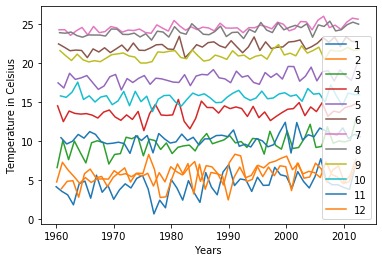

<Figure size 432x288 with 0 Axes>

In [4]:
mainControl = WorldController()

In [5]:
arrayOfDataToTrain = mainControl.getDfToTrain(sf6_obj.monthDataFrame[sf6_obj.monthDataFrame.index.year <=2012], n2o_obj.monthDataFrame[n2o_obj.monthDataFrame.index.year <=2012], co2_obj.monthDataFrame[co2_obj.monthDataFrame.index.year <=2012], CH4_obj.monthDataFrame[CH4_obj.monthDataFrame.index.year <=2012])
    
#now we have an array with dataframes for each month, return several models.  One for each month.
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

So something went wrong, before we move on, we are going to check the correlation of the data we currently have.  Next step is to try and gather more data that can be used for weather predictions.

In [6]:
print(arrayOfDataToTrain[0].columns)

arrayOfDataToTrain[0].corr()[['AverageTemperature']].sort_values('AverageTemperature')


Index(['AverageTemperature', 'Latitude', 'Longitude', 'sf6', 'n2o', 'co2',
       'ch4'],
      dtype='object')


AverageTemperature
Latitude                     -0.821355
Longitude                    -0.331798
co2                           0.072663
n2o                           0.078162
sf6                           0.078989
ch4                           0.085537
AverageTemperature            1.000000

Below shows visual representation of the correlation that was calculated from above.  

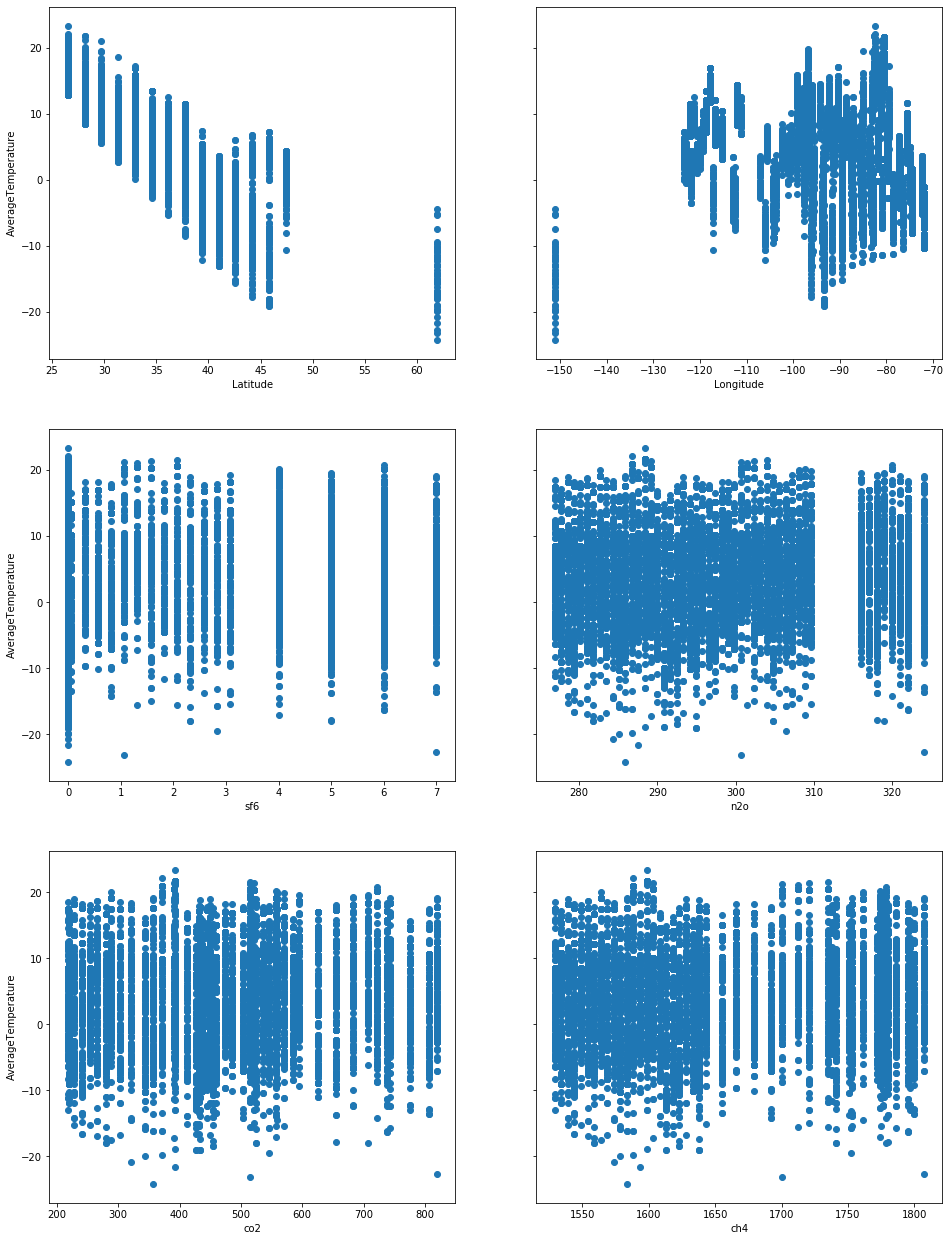

In [7]:
predictors = arrayOfDataToTrain[0].columns[1:].to_list()

df2 = arrayOfDataToTrain[0][['AverageTemperature'] + predictors]
#print(arrayOfDataToTrain[0].Longitude)
plt.rcParams['figure.figsize'] = [16, 22]

# call subplots specifying the grid structure we desire and that 
# the y axes should be shared
fig, axes = plt.subplots(nrows=3, ncols=2, sharey=True)

# Since it would be nice to loop through the features in to build this plot
# let us rearrange our data into a 2D array of 6 rows and 3 columns
arr = np.array(predictors).reshape(3, 2)

# use enumerate to loop over the arr 2D array of rows and columns
# and create scatter plots of each meantempm vs each feature
for row, col_arr in enumerate(arr):
    for col, feature in enumerate(col_arr):
        axes[row, col].scatter(df2[feature], df2['AverageTemperature'])
        if col == 0:
            axes[row, col].set(xlabel=feature, ylabel='AverageTemperature')
        else:
            axes[row, col].set(xlabel=feature)
plt.show()

Because latitude had the best correlation to weather, we will cluster all our data with latitude being the labels.  If we try to us latitude and longitude as columns when predicting, the values wouldn't mean anything.  

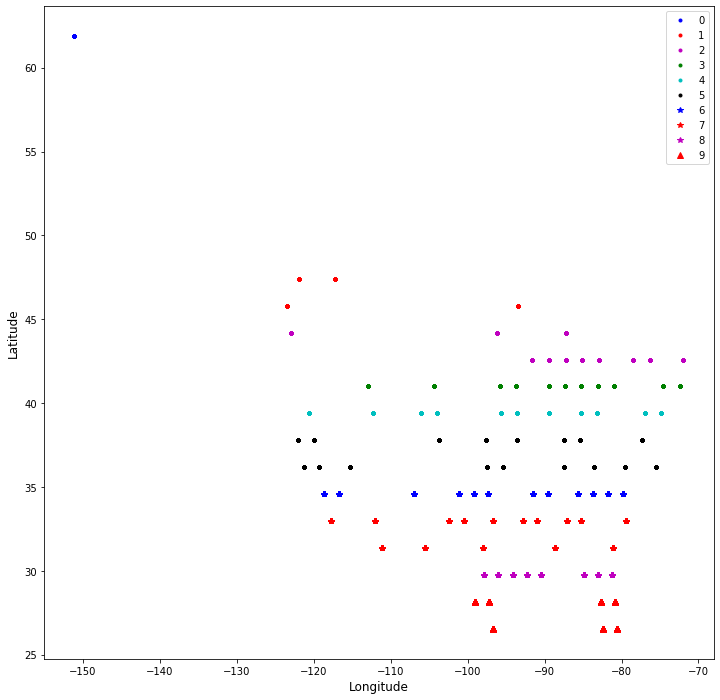

In [8]:
#from geohash2 import encode
#for df in arrayOfDataToTrain:
#    for index, row in df.iterrows():
#        print(encode(row['Latitude'],row['Longitude'], precision=2))

#datafile = cbook.get_sample_data('E:\OneDrive - University of Georgia\Data Science\project\usa.jpg')
#img = imread("E:/OneDrive - University of Georgia/Data Science/project/usa.jpg")

from sklearn.cluster import KMeans
id_n= 10
j = 0 
for df in arrayOfDataToTrain:
    X = df.loc[:, ['Longitude', 'Latitude']]

    kmeans = KMeans(n_clusters=id_n, random_state=0).fit(np.array(X.loc[:,'Latitude'].to_list()).reshape(-1,1))
    #kmeans = KMeans(n_clusters=id_n, random_state=0).fit(X)
    ptsymb = np.array(['b.','r.','m.','g.','c.','k.','b*','r*','m*','r^'])
    myArray = np.zeros(len(kmeans.labels_))
    for i in range(len(kmeans.labels_)):
        if kmeans.labels_[i] == 0:
            myArray[i] = 7
        elif kmeans.labels_[i] == 1:
            myArray[i] = 3
        elif kmeans.labels_[i] == 2:
            myArray[i] = 9
        elif kmeans.labels_[i] == 3:
            myArray[i] = 1
        elif kmeans.labels_[i] == 4:
            myArray[i] = 5
        elif kmeans.labels_[i] == 5:
            myArray[i] = 0
        elif kmeans.labels_[i] == 6:
            myArray[i] = 2
        elif kmeans.labels_[i] == 7:
            myArray[i] = 8
        elif kmeans.labels_[i] == 8:
            myArray[i] = 4
        elif kmeans.labels_[i] == 9:
            myArray[i] = 6
    df['LongLat'] = myArray
    id_label = myArray
    if j == 0:
        plt.figure(figsize=(12,12))
        plt.ylabel('Latitude', fontsize=12)
        plt.xlabel('Longitude', fontsize=12)
        arrayOfClusters = []
        for i in range(id_n):

            cluster=np.where(id_label==i)[0]
            plt.plot(X.Longitude[cluster].values,X.Latitude[cluster].values ,ptsymb[i], label=i)
        plt.legend()
        plt.show()
    j+=1


Average: -31.519195867668216


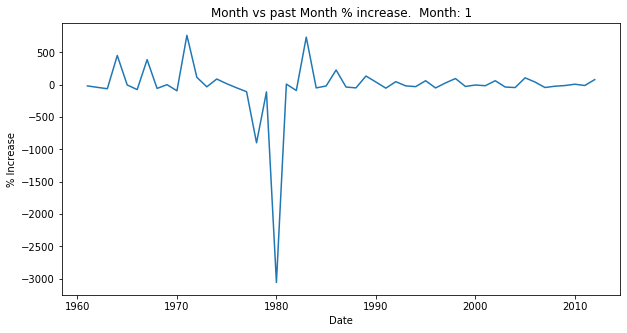

Average: 12.253431303831617


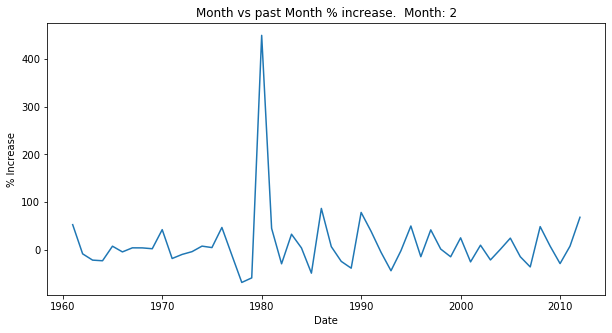

Average: 3.1323139523678565


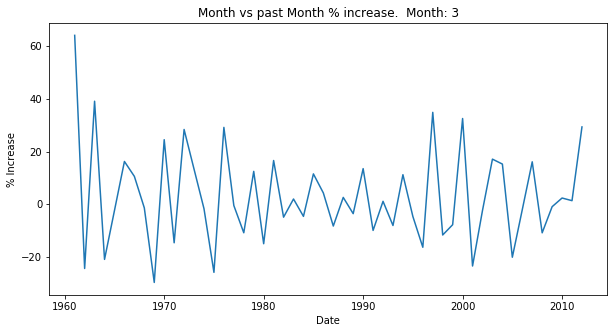

Average: 0.4128483068862405


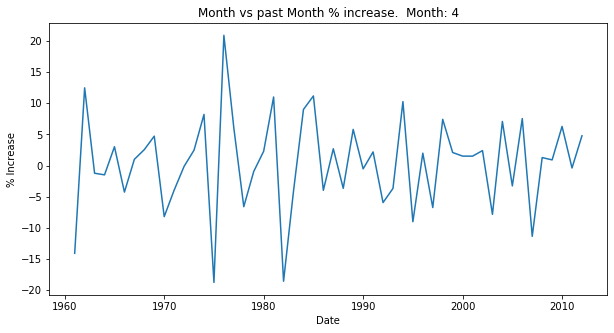

Average: 0.32911043993269895


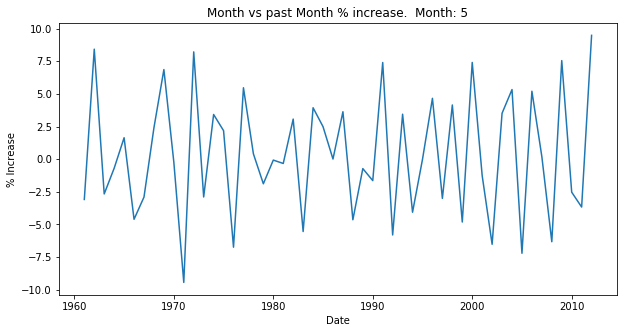

Average: 0.08284090736602558


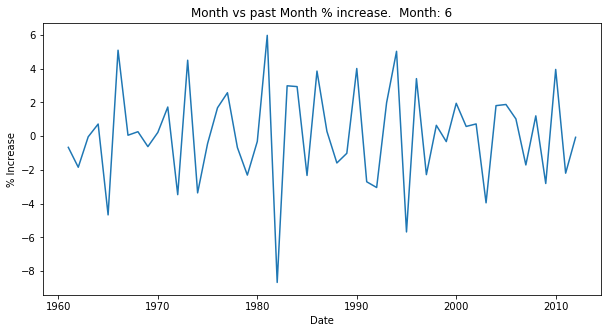

Average: 0.11319670160505864


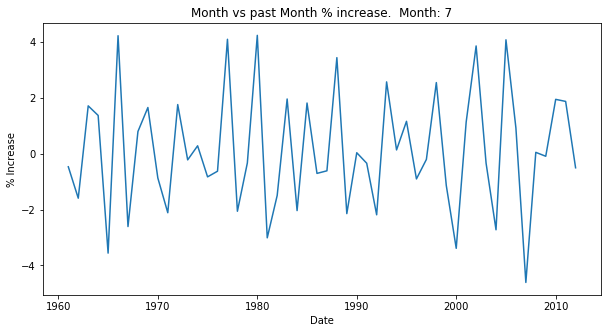

Average: 0.116870695311162


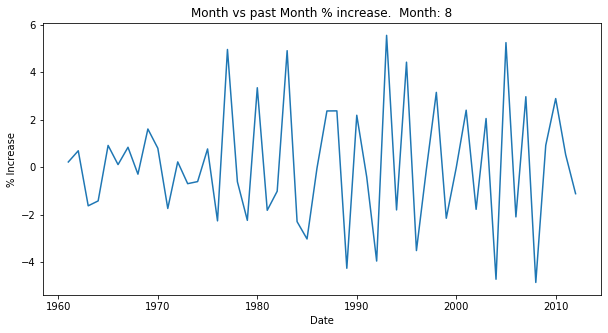

Average: 0.06845376917959577


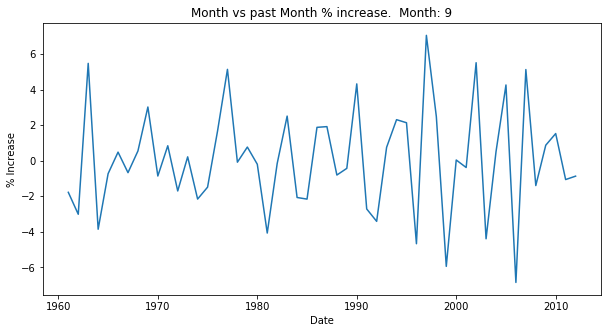

Average: 0.18525417009903034


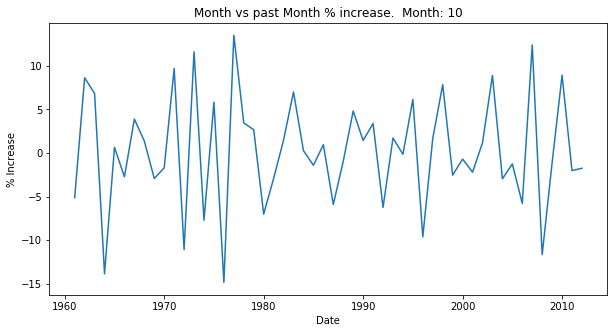

Average: 0.5113846854565163


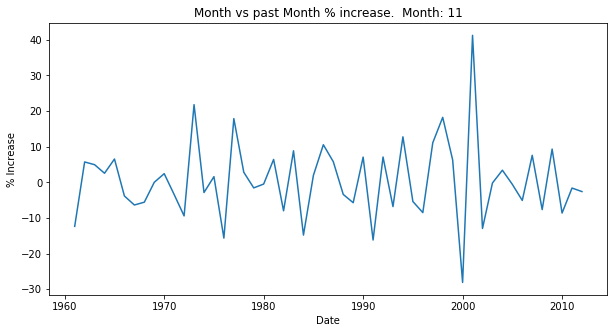

Average: 15.00257456853826


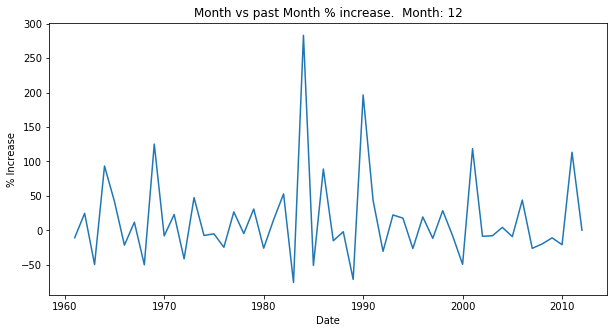

In [26]:
for keys in mainControl.getMonthDict().keys():

    df = mainControl.getMonthDict()[keys]
    df = df.reset_index()
    df['LongLat'] = arrayOfDataToTrain[0]['LongLat']
    df = df.groupby(by=['dt','LongLat']).agg('mean')['AverageTemperature']
    mtpy = []
    s = []
    for x in df:
        s.append(x)
        if len(s) == 10:
            mtpy.append(sum(s)/10)
            s = []
    print('Average: {}'.format(sum(IPA(mtpy))/52))
    plt.figure(figsize=(10,5))
    plt.plot([1961 + x for x in range(52)], IPA(mtpy))
    plt.title('Month vs past Month % increase.  Month: {}'.format(keys))
    plt.ylabel('% Increase')
    plt.xlabel('Date')
    plt.show()

So, predicting temperature with greenhouse gases may not have been the best idea.  So let us try to use the data we do have by predicting how climate change will change.  

<Figure size 720x720 with 0 Axes>

<Figure size 360x360 with 0 Axes>

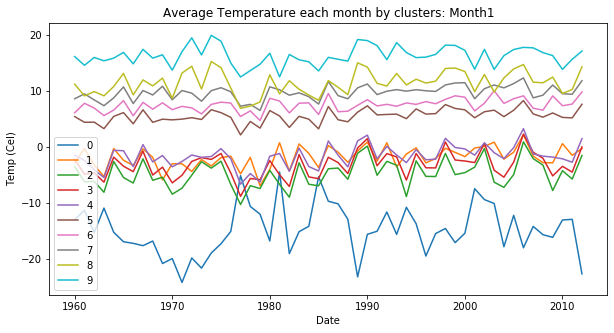

<Figure size 360x360 with 0 Axes>

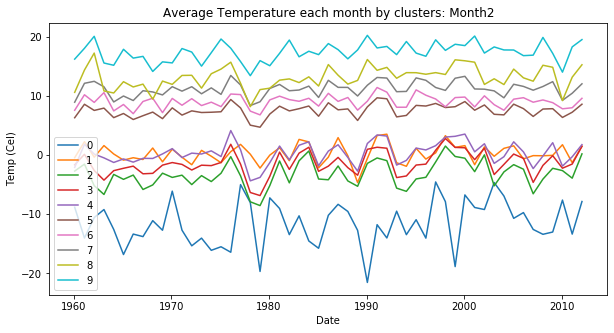

<Figure size 360x360 with 0 Axes>

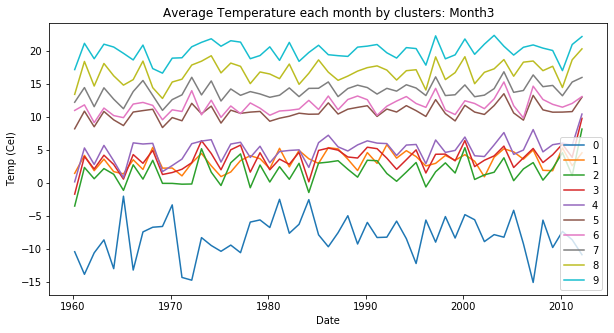

<Figure size 360x360 with 0 Axes>

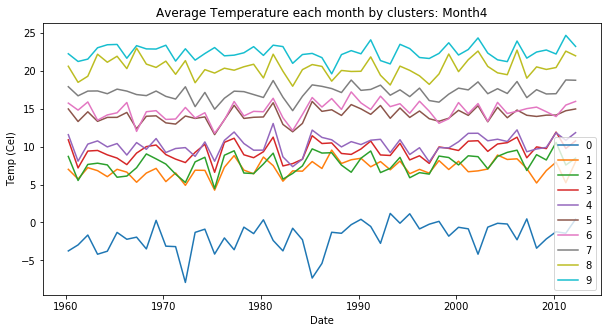

<Figure size 360x360 with 0 Axes>

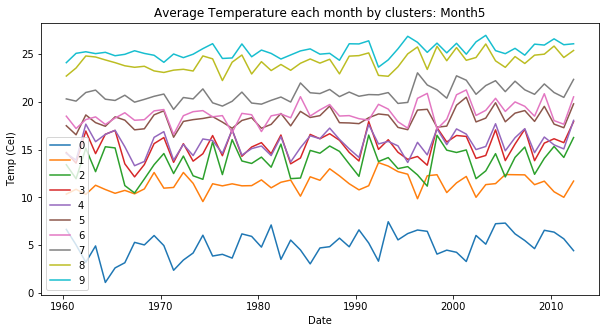

<Figure size 360x360 with 0 Axes>

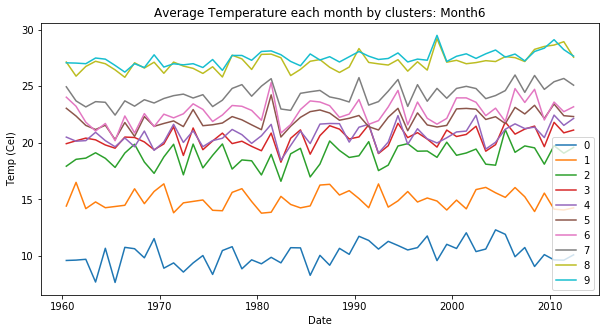

<Figure size 360x360 with 0 Axes>

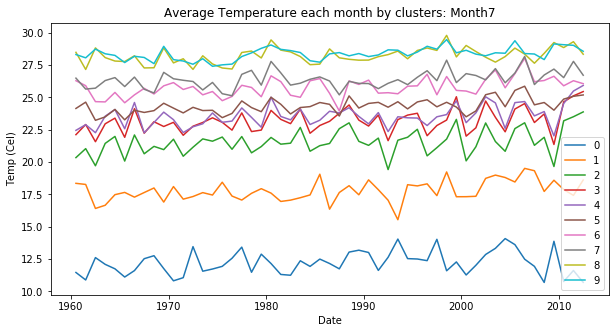

<Figure size 360x360 with 0 Axes>

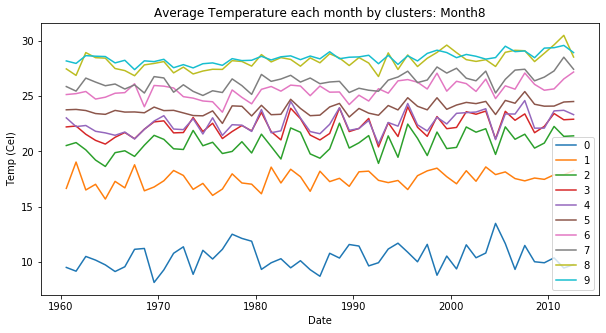

<Figure size 360x360 with 0 Axes>

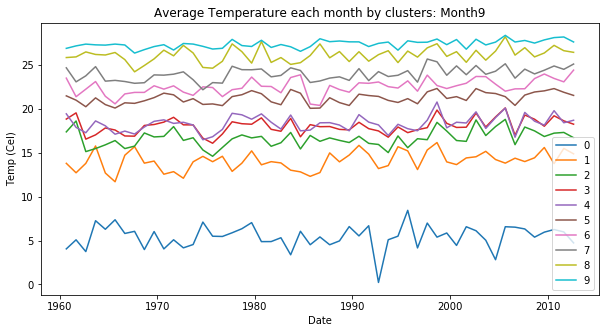

<Figure size 360x360 with 0 Axes>

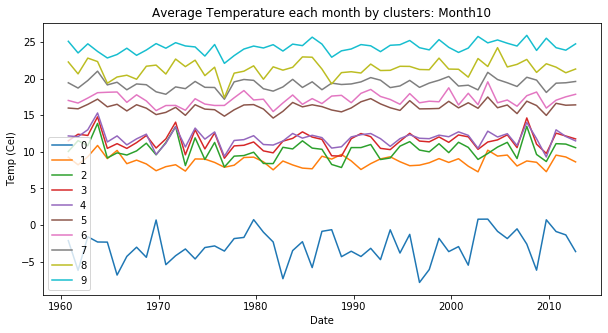

<Figure size 360x360 with 0 Axes>

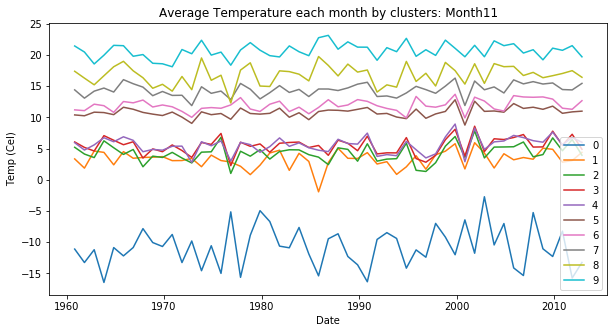

<Figure size 360x360 with 0 Axes>

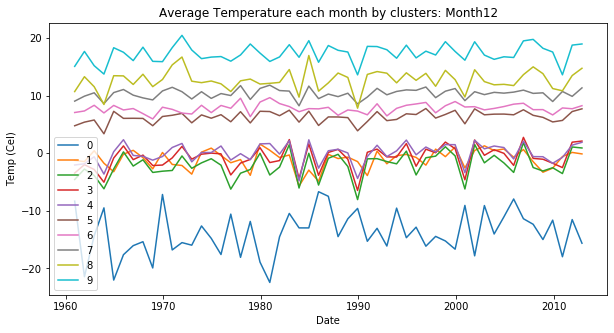

In [27]:
mainControl.getMonthDict()
import seaborn as sns
plt.figure(figsize=(10,10))
for keys in mainControl.getMonthDict().keys():
    plt.figure(figsize=(5,5))
    df = mainControl.getMonthDict()[keys]
    df = df.reset_index()
    df['LongLat'] = arrayOfDataToTrain[0]['LongLat']
    df = df.groupby(by=['dt','LongLat']).agg('mean')['AverageTemperature']

    plt.figure(figsize=(10,5))
    plt.xlabel('Date')
    plt.ylabel('Temp (Cel)')
    plt.title('Average Temperature each month by clusters: Month{}'.format(keys))
    for i in range(len(df.unstack(level=1).columns)):
        sns.lineplot(data=df.unstack(level=1)[i])
    plt.legend(range(10))
    plt.show()
    

While we have the data, might as well try out a MLP 

In [11]:
monthData = arrayOfDataToTrain.copy()
for i in range(len(monthData)):
    monthData[i] = monthData[i].drop(columns=['Longitude','Latitude'])


In [12]:
def MSE(actual, pred):
    size = len(actual)
    value = np.sum( (actual - pred)**2)
    return value / size 

In [18]:
from sklearn.neural_network import MLPRegressor
MLPModel1 = []
i = 1
for df in monthData:
    
    x =  df[df.columns[1:]]
    y = df[df.columns[0]]
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.8, random_state=42)
    mlpMod = MLPRegressor(max_iter=500, random_state=21).fit(X_train, y_train)
    MLPModel1.append(mlpMod)
    print('Month: {}, R^2 Score: {}'.format(i,mlpMod.score(X_test,y_test)))
    #mlpMod.predict(X_test)
    #print(X_test)
    print('MSE {}'.format(MSE(y_test, mlpMod.predict(X_test))))
    #df['Predicted_Temp'] = linMod.predict(X_test)
    i+=1


Month: 1, R^2 Score: 0.6994980097354437
MSE 16.076046544801024
Month: 2, R^2 Score: 0.743687190894635
MSE 12.546941531085356
Month: 3, R^2 Score: 0.7964288983009328
MSE 7.162683825401632
Month: 4, R^2 Score: 0.7583520992364527
MSE 5.654061385469848
Month: 5, R^2 Score: 0.533082119103706
MSE 8.781440986921163
Month: 6, R^2 Score: 0.41963970408857093
MSE 9.764811843271492
Month: 7, R^2 Score: 0.3242854685421691
MSE 10.178829296823142
Month: 8, R^2 Score: 0.42490770042105297
MSE 8.577549479203533
Month: 9, R^2 Score: 0.6969705042737271
MSE 5.09466488709219
Month: 10, R^2 Score: 0.7993041243479527
MSE 4.515319429715565
Month: 11, R^2 Score: 0.7599218605132356
MSE 7.2467527964942375
Month: 12, R^2 Score: 0.7386098697130635
MSE 11.323580310639006


Now using new greenhouse gases, let us predict how the temperature is in Georgia for years 2012 to 2014.

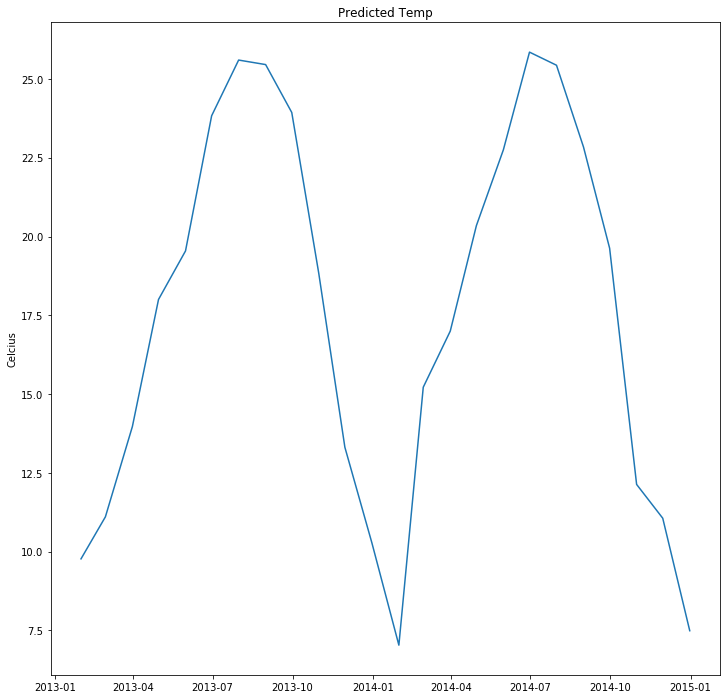

In [38]:
sf6_test = sf6_obj.monthDataFrame[sf6_obj.monthDataFrame.index.year>2012 ]
sf6_test = sf6_test[sf6_test.index.year<=2014 ]
ch4_test = CH4_obj.monthDataFrame[CH4_obj.monthDataFrame.index.year>2012]
ch4_test = ch4_test[ch4_test.index.year<=2014 ]
co2_test = co2_obj.monthDataFrame[co2_obj.monthDataFrame.index.year>2012]
co2_test = co2_test[co2_test.index.year<=2014]
n2o_test = n2o_obj.monthDataFrame[n2o_obj.monthDataFrame.index.year>2012]
n2o_test = n2o_test[n2o_test.index.year<=2014]
LongLat = arrayOfDataToTrain[0]['LongLat'].unique()

allTest = pd.concat([sf6_test, n2o_test, co2_test, ch4_test], axis=1)
allTest1 = allTest.reset_index(drop=True)
allTest1.columns=['sf6', 'n2o', 'co2', 'ch4']
allTest1['LongLat'] = [7] *  n2o_test.size
i = 0
predicted = []
for index,row  in allTest1.iterrows():
    
    predicted.append(MLPModel1[i].predict(np.array(row).reshape(1,-1)))
    i+=1
    if i == 11:
        i=0
plt.figure(figsize=(12,12))
plt.title('Predicted Temp')
plt.ylabel('Celcius')
plt.plot(allTest.index, predicted)
plt.show()

Produce results for linear regression.  

Month: 1, R^2 Score: 0.7189893585008572
MSE 15.033311920321918
Month: 2, R^2 Score: 0.7453092305599432
MSE 12.467539971277404
Month: 3, R^2 Score: 0.8081745664847488
MSE 6.7494104933001
Month: 4, R^2 Score: 0.7896545123339389
MSE 4.921649621877899
Month: 5, R^2 Score: 0.6333069557825355
MSE 6.896487497820508
Month: 6, R^2 Score: 0.44274120437862935
MSE 9.376119154920994
Month: 7, R^2 Score: 0.35381396127991016
MSE 9.734017955676627
Month: 8, R^2 Score: 0.4661745298437313
MSE 7.962051286162116
Month: 9, R^2 Score: 0.7017649490776829
MSE 5.01405857668246
Month: 10, R^2 Score: 0.8024737190941371
MSE 4.444008882374853
Month: 11, R^2 Score: 0.7769746467653507
MSE 6.7320148585682125
Month: 12, R^2 Score: 0.7364877890543597
MSE 11.41551014264188


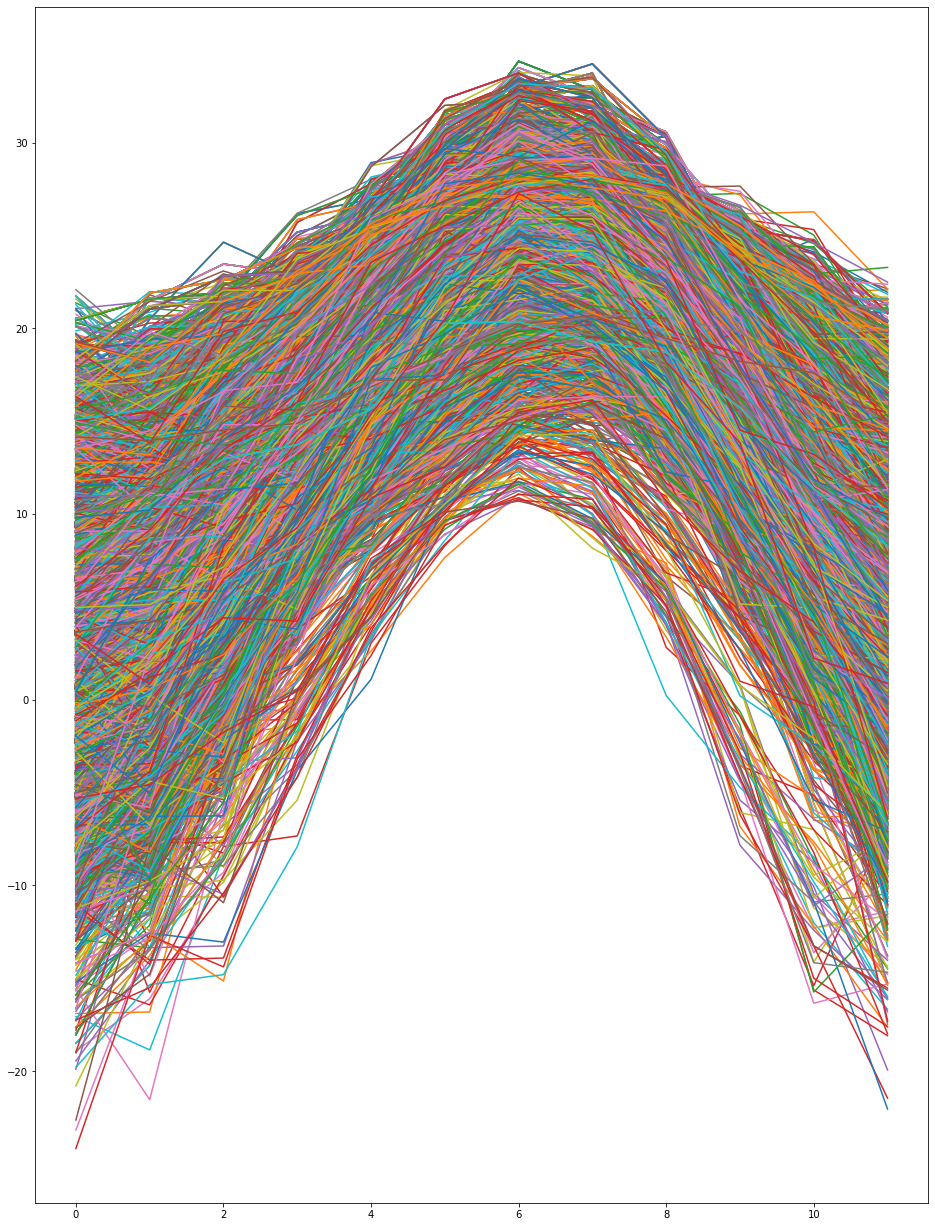

In [41]:
linearRegressionArray = []
from sklearn.linear_model import LinearRegression
i = 1
listPredicted = []
listActual = []
for df in monthData:
    x =  df[df.columns[1:]]
    y = df[df.columns[0]]
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.8, random_state=42)
    linModel = LinearRegression()
    linModel.fit(X_train, y_train)
    linearRegressionArray.append(linModel)
    print('Month: {}, R^2 Score: {}'.format(i,linModel.score(X_test,y_test)))
    listPredicted.append(linModel.predict(X_test))
    listActual.append(y_test)
    print('MSE {}'.format(MSE(y_test, linModel.predict(X_test))))
    i+=1
plt.plot(listPredicted)
plt.plot(listActual)
plt.show()

Now using new greenhouse gases, let us predict how the temperature is in Georgia for years 2012 to 2014.

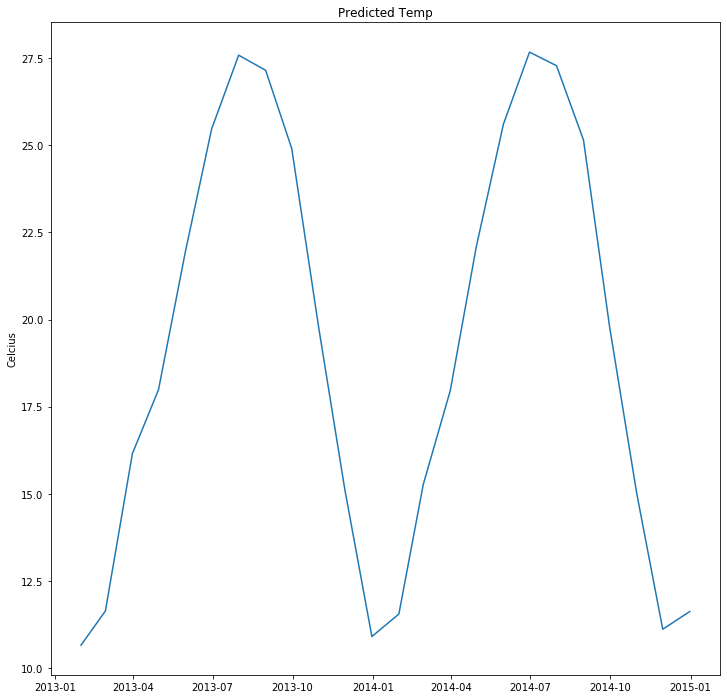

In [37]:
i = 0
predicted = []
for index,row  in allTest1.iterrows():
    predicted.append(linearRegressionArray[i].predict(np.array(row).reshape(1,-1)))
    i+=1
    if i == 11:
        i=0
plt.figure(figsize=(12,12))
plt.plot(allTest.index, predicted)
plt.title('Predicted Temp')
plt.ylabel('Celcius')
plt.show()

In [36]:
from scipy.stats import f_oneway
for i in range(len(listPredicted)) :
    print('Month {}  \tFvalue: {}, \tpvalue: {}'.format(i+1,*f_oneway(listPredicted[i], listActual[i])))


Month 1  	Fvalue: 1.5890526954105892, 	pvalue: 0.20747502618780225
Month 2  	Fvalue: 0.37964778629467044, 	pvalue: 0.5377982311805974
Month 3  	Fvalue: 0.003103447280431751, 	pvalue: 0.9555744649952287
Month 4  	Fvalue: 0.6565483466050455, 	pvalue: 0.4177900059950048
Month 5  	Fvalue: 0.0839156552031999, 	pvalue: 0.7720622918756306
Month 6  	Fvalue: 0.17319712729202202, 	pvalue: 0.6772900091658882
Month 7  	Fvalue: 0.5130800659996877, 	pvalue: 0.47381622604955176
Month 8  	Fvalue: 0.6560791102209693, 	pvalue: 0.4179564315136326
Month 9  	Fvalue: 0.1466925931296517, 	pvalue: 0.7017200218328492
Month 10  	Fvalue: 0.5410376531038025, 	pvalue: 0.46201092354116924
Month 11  	Fvalue: 0.010846582932119765, 	pvalue: 0.9170537073589293
Month 12  	Fvalue: 0.08950864083629878, 	pvalue: 0.7648056017890423


## Conclusion

Using correlation, latitude is the best bet of predicting weather for a given year.  The greenhouse gases do not hold much presence in terms of power.  With each month having a p-value greater than .1, our anova test does not prove our hypothesis that greenhouse gases can predcit weather.  There were many factors of concern when creating this model.  

1) We could only get such limited free data about greenhouse gases.  We had to parse, aggregate and make a linear prediction graph from 1980 to 1960 to fill in nan values for the greenhouses to be used in tangent with 1960 -1980 weather data.  

2) Greenhouse gases are dependent  on the greenhouse gases left there from prevous years however this is not accounted for, neither are greenhouse gas per capita so we could not calculate every humans footprint. 

3) With Co2 data, this was extracted and could not be put into levels at time of data collection such as the other greenhouse gases were condensed to.  

4) The data we did get were split into an average over months, as we were given year data.  This may not be a big issue but it was apart of the process.

5) Climate factors should have been taken into consideration when building this model for us to predict weather better.  


## Future 

This project could be improved by the above factors.  As well as being used when connected to a rasberry pi that gathers weather data in athens to continously update the learning model.  The only issue here is that greenhouse gases would need to be captured as well or to find a data source that updates greenhouse gases on the regular.  